In [1]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from pylab import *
from pyntcloud import PyntCloud
from matplotlib.pyplot import figure

INFO - 2021-12-19 01:23:16,782 - utils - NumExpr defaulting to 8 threads.


In [2]:
print("Load the point cloud model")
venice = o3d.io.read_point_cloud('/Users/liyuxiao/Downloads/venice_building_height/google_earth_one2one.ply')

Load the point cloud model


# Height Visualization
## City Elevation Model Construction
### Plane segmentation
Open3D also supports segmententation of geometric primitives from point clouds using RANSAC. To find the plane with the largest support in the point cloud, we can use segment_plane. The method has three arguments: distance_threshold defines the maximum distance a point can have to an estimated plane to be considered an inlier, ransac_n defines the number of points that are randomly sampled to estimate a plane, and num_iterations defines how often a random plane is sampled and verified. The function then returns the plane as (𝑎,𝑏,𝑐,𝑑) such that for each point (𝑥,𝑦,𝑧) on the plane we have 𝑎𝑥+𝑏𝑦+𝑐𝑧+𝑑=0. The function further returns a list of indices of the inlier points.

In [5]:
plane_model, inliers = venice.segment_plane(distance_threshold=0.01,
                                         ransac_n=3,
                                         num_iterations=1000)
[a, b, c, d] = plane_model
print(f"Plane equation: {a}x + {b}y + {c}z + {d} = 0")

Plane equation: 0.00029666339510262967x + 0.0007409272383139231y + 0.999999681508778z + -0.005621427742310253 = 0


Once the plane equation is obtained in the previous step, we could start calculating the height of buildings. In the first step, we calculate the relative height of the buildings based on the formula of point-to-plane distance. The coordinate information of each point could be accessed by the 'points' attribute of the ‘PointCloud’ object with the help of 'Open3D'. Since we already have the plane equation, using this formula, we could obtain the distances between each point and the plane and save them in a (n, 1) array.

To visualise the height of the building, the first method is to change the colors of the points in the PointCloud model. For each point in the ‘PointCloud’, it has a ‘Colors' attribute. By calling this attribute, an (n, 3) array of value range [0, 1], containing RGB colors information of the points will be returned. Therefore, by normalising the ‘distances array’ values to the range of [0,1] and expanding the 'distances array' to three dimensions by replication, we get a (n, 3) ‘height array' in the form of (n, 3) 'colors array’.

In [6]:
venice_coordinate = np.asarray(venice.points)
distance = np.zeros((len(venice_coordinate),1))
for i in range(len(venice_coordinate)):
    distance[i] = abs(venice_coordinate[i,0]*a+ venice_coordinate[i,1]*b+ venice_coordinate[i,2]*c +d)/np.sqrt(a**2+b**2+c**2)
distance = distance/np.max(np.max(distance))
distance = np.hstack((distance,distance,distance))
venice.colors = o3d.utility.Vector3dVector(distance)

In [7]:
o3d.visualization.draw_geometries([venice])

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [8]:
o3d.io.write_point_cloud('/Users/liyuxiao/Downloads/venice_building_height/google_earth_height_model.ply', venice)

True

##  City Elevation Map Construction
In this section, we transform the PointCloud coordinates information into a DataFrame, and plot the z-coordinate on a XoZ plane 2D map.

In [9]:
cloud = PyntCloud.from_file('/Users/liyuxiao/Downloads/venice_building_height/google_earth_one2one.ply')

Describe the data

In [10]:
cloud.points.describe()

x             y             z            nx            ny  \
count  4.093530e+06  4.093530e+06  4.093530e+06  4.093530e+06  4.093530e+06   
mean   6.686604e+00 -5.346277e+00  6.616662e+00 -8.815960e-03 -6.040324e-03   
std    8.941692e+02  1.177987e+03  7.039161e+00  3.230940e-01  3.201820e-01   
min   -2.077989e+03 -2.827191e+03 -2.360736e+01 -9.027069e-01 -9.276316e-01   
25%   -6.878615e+02 -8.370256e+02  4.482318e-01 -1.471397e-01 -1.383019e-01   
50%   -3.603732e+01  8.539259e+01  5.274564e+00 -2.297957e-03  3.311503e-04   
75%    7.031517e+02  8.852336e+02  1.208968e+01  1.323771e-01  1.176808e-01   
max    1.920850e+03  2.432169e+03  9.848128e+01  9.026994e-01  9.276414e-01   

                 nz           red         green          blue  
count  4.093530e+06  4.093530e+06  4.093530e+06  4.093530e+06  
mean   6.500330e-01  1.088055e+02  1.073867e+02  9.607085e+01  
std    3.439456e-01  5.019801e+01  3.726008e+01  3.723417e+01  
min   -9.228545e-01  0.000000e+00  0.000000e+00  0.000000e+00  
25%    4.870882e-01  6.700000e+01  8.900000e+01  7.500000e+01  
50%    8.170033e-01  9.300000e+01  1.020000e+02  8.800000e+01  
75%    9.057527e-01  1.530000e+02  1.250000e+02  1.150000e+02  
max    9.276541e-01  2.550000e+02  2.550000e+02  2.550000e+02

Transform the points to DataFrame

In [11]:
pointframe = cloud.points

Plot the z coordinate

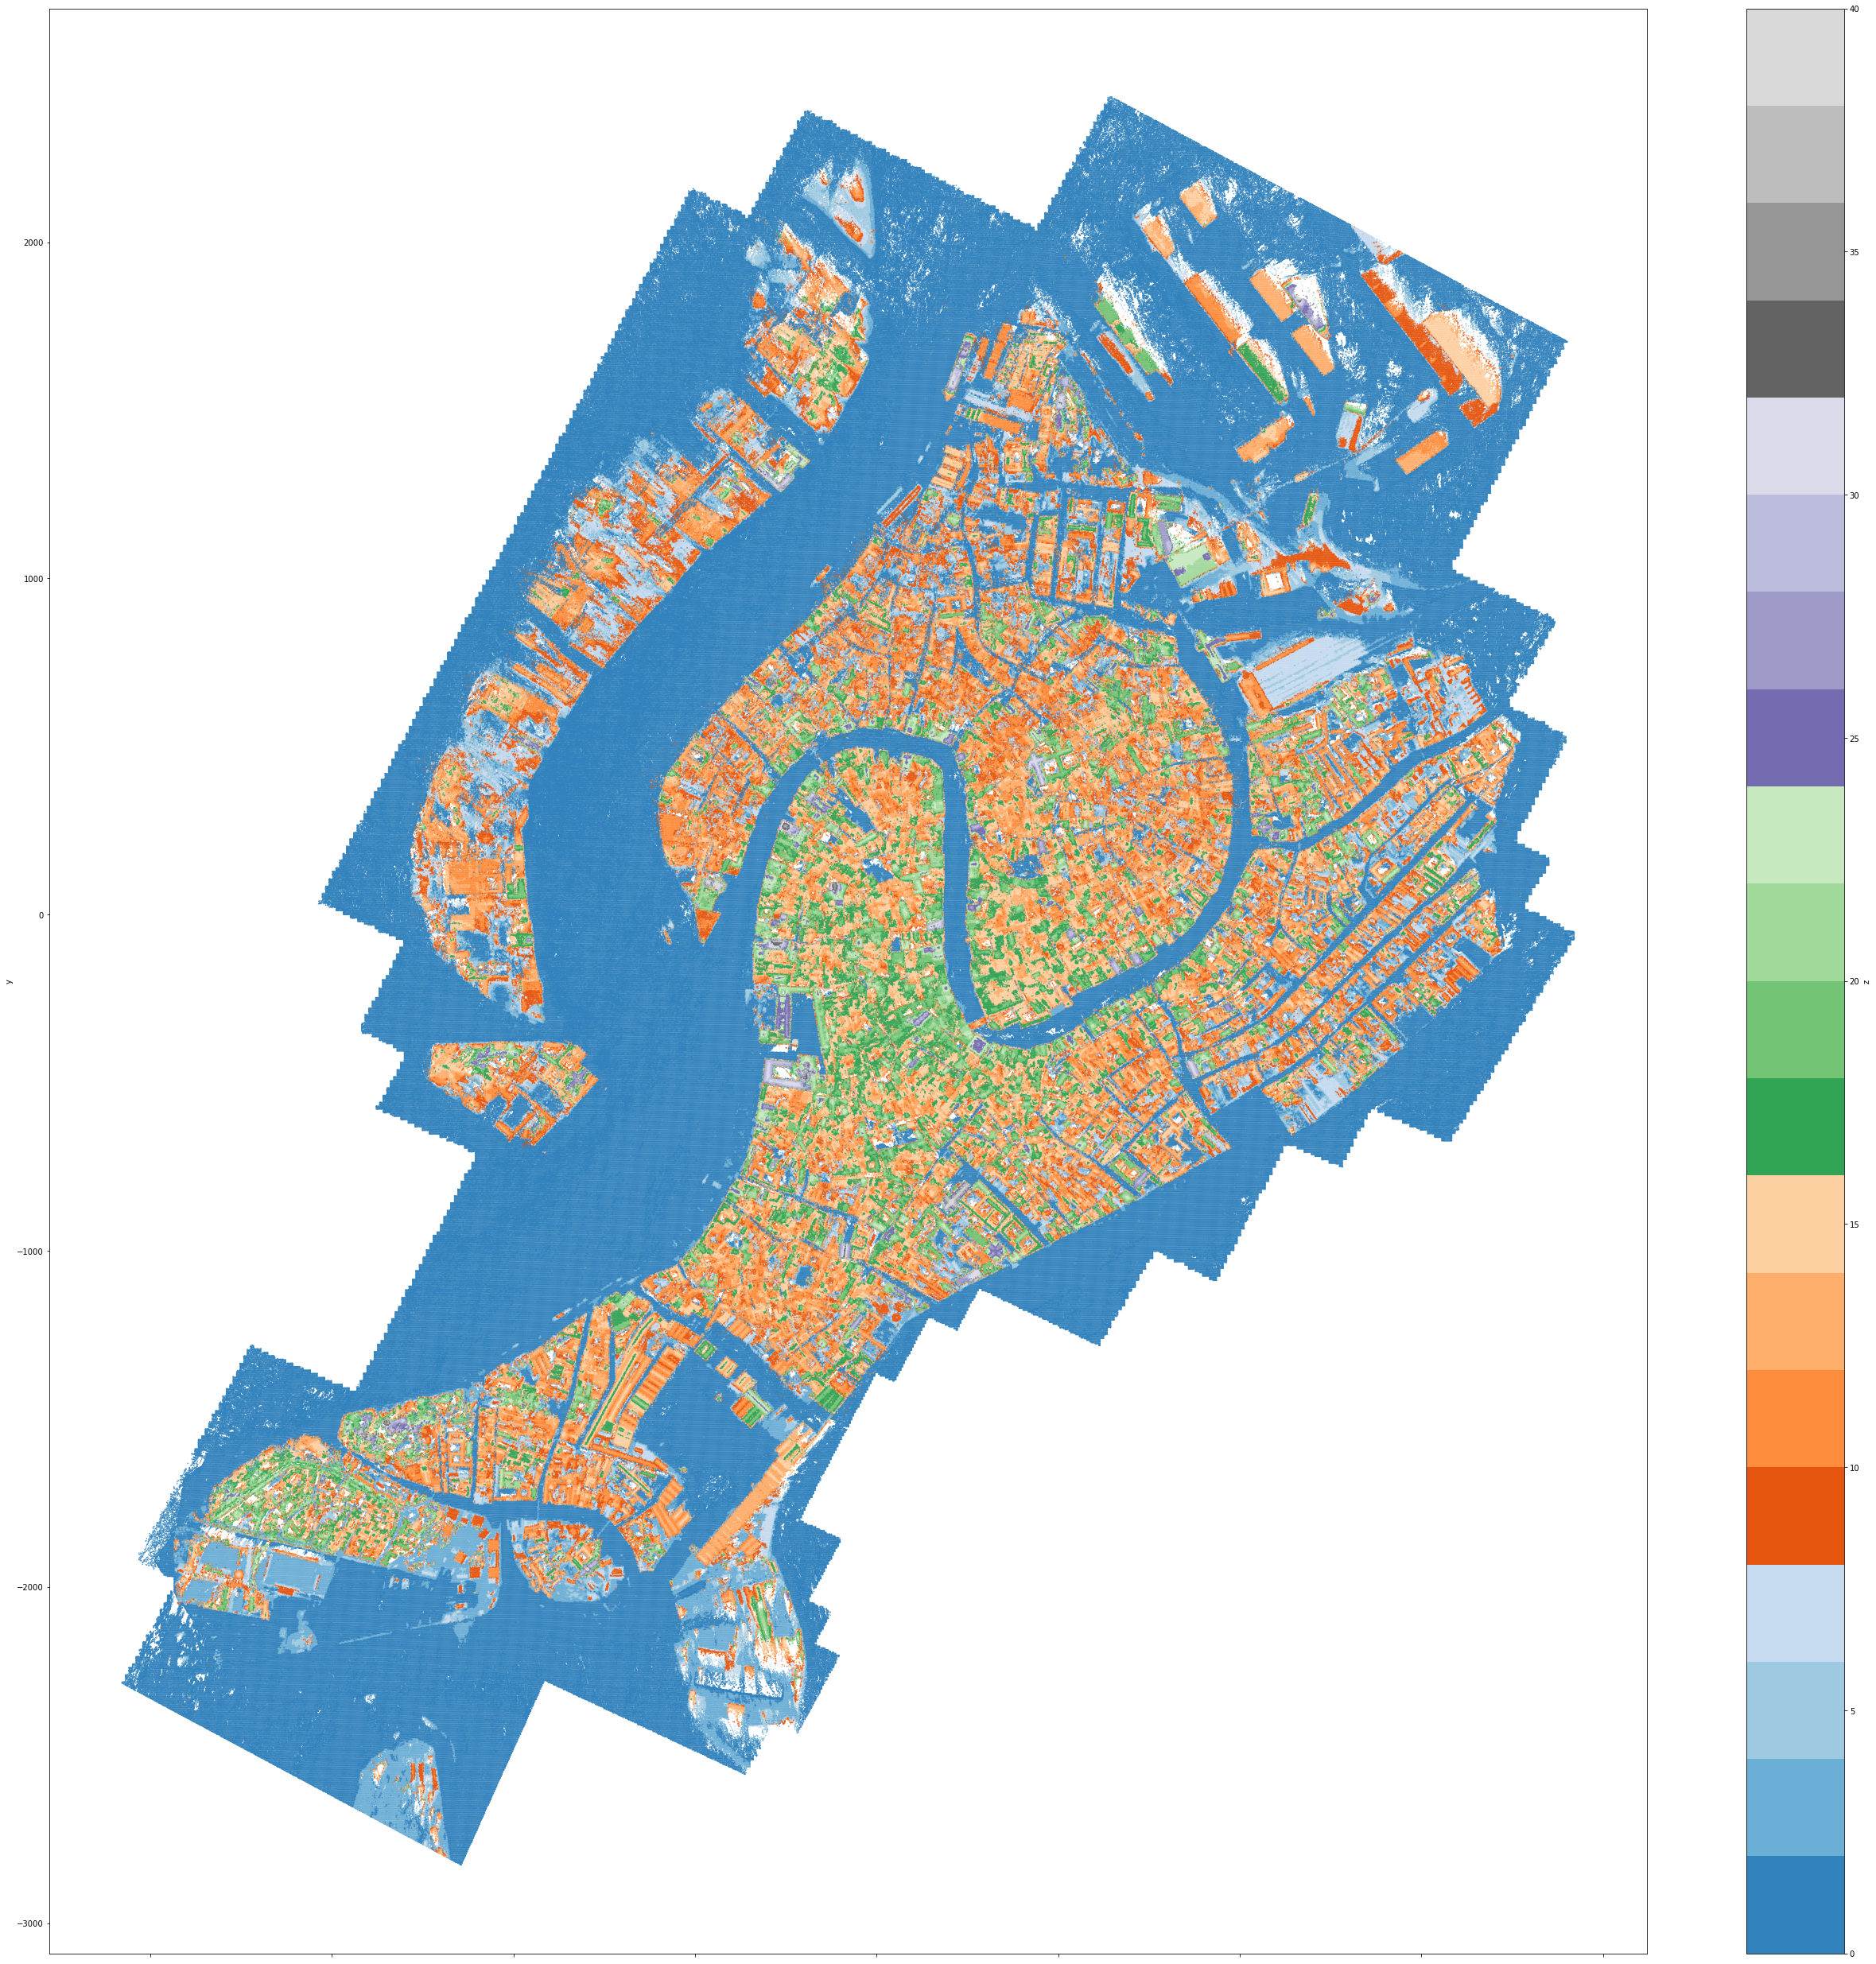

In [12]:
cmap = cm.get_cmap('Greys',20)    # 20 discrete colors
pointframe.plot.scatter(x="x", y="y", c="z", s=0.2, cmap=cmap, vmin=0, vmax=40, figsize=(45,45))
plt.savefig('Height_tab20c.png')
plt.show()